# Machine Learning Foundation

## Course 5, Part h: Autoencoders LAB

## Learning Objectives 

1. Implement the following dimensionality reduction techniques on the MNIST data:
    * PCA
    * Autoencoders
    * Variational autoencoders
2. Use appropriate scoring metrics to compare the performance of each.

## MNIST data

Throughout this lesson, we'll be working with the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains 70,000 handwritten black-and-white images, which are traditionally split into 60k training images and 10k validation images.

In [41]:
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data();

### Preprocess MNIST

We'll preprocess by scaling images pixels to be between 0 and 1.

In [42]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### Part 1: PCA

We'll use PCA as a baseline with which we can compare our deep learning models.

For PCA we'll treat each image like a "row" of data and flatten our data, so each observation is 784 columns:

In [43]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


Recall that PCA will do a **matrix decomposition** of this data to find the **eigenvalues** - these **eigenvalues** will be the **principal components** of the data, or the "latent features" that describe a maximal amount of variance in the data.

PCA works better if our features are scaled, so let's do that. 

In [44]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [45]:
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

In [46]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


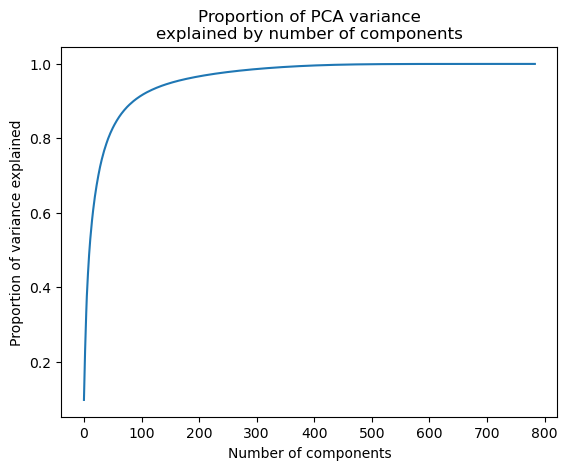

In [47]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

We need about 250 components to explain 90% of the variance in the data!

For visualization purposes, let's extract just two components and plot them:

In [48]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

Variance explained with 2 components: 0.17


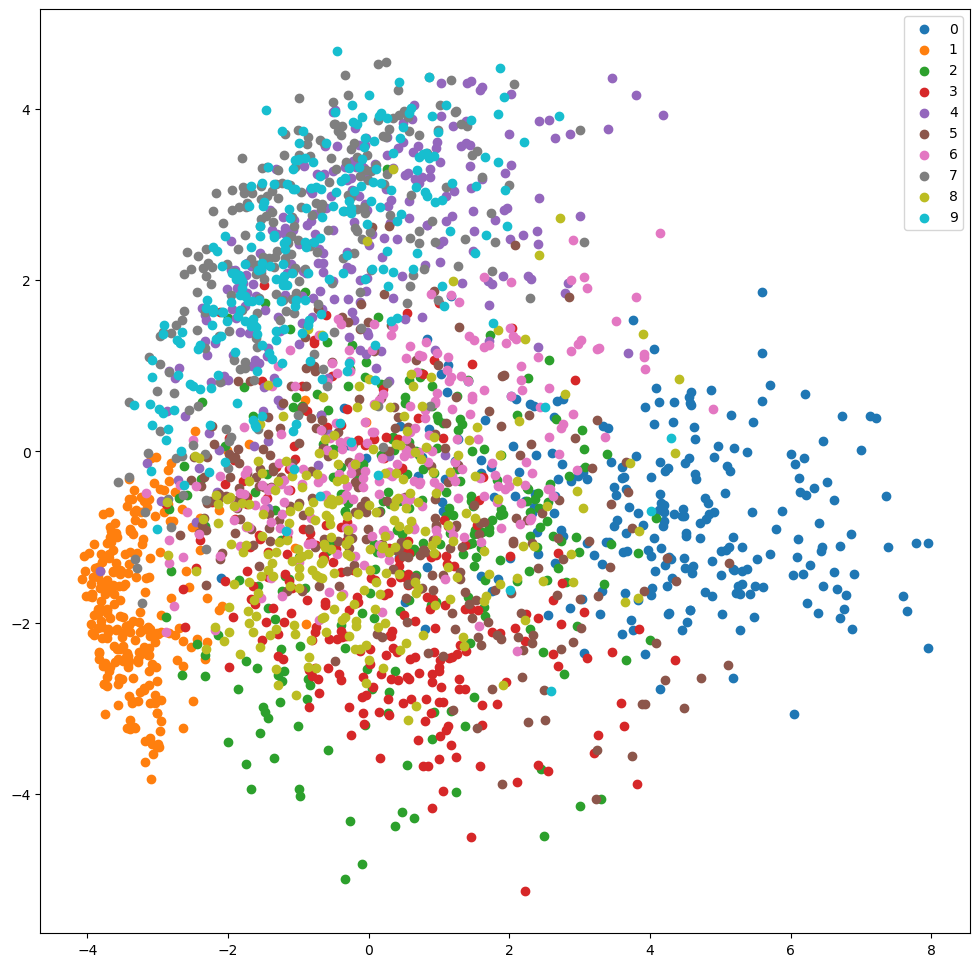

In [49]:
num_images_per_class = 250
fig = plt.figure(figsize=(12,12))
for number in list(range(10)):
    mask = y_train == number
    x_data = mnist_data_2[mask, 0][:num_images_per_class]
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend();

We can already see that the latent features PCA is learning _somewhat_ disentangle the features here, and a neural network could certainly help with this.

### Scoring PCA

What we really care about is: how good is PCA at creating a low dimensional representation of the MNIST data?

As with all models, we should test performance on a different dataset than we trained on:

In [50]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

Variance explained with 64 components: 0.86


In [51]:
s = MinMaxScaler().fit(x_test_flat)
x_test_scaled = s.transform(x_test_flat)

In [52]:
x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

In [53]:
x_test_reconstructed_64.shape

(10000, 784)

In [54]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [55]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [56]:
mse_reconstruction(true, reconstructed)

90.582344

Average MSE of **90.6**, using 64 components, for PCA.

### Simple AE

Now let's build an autoencoder! Fundamentally, an autoencoder is an neural network where the input is the same as the output. The hope for such networks is that one of the hidden layers will "learn a compressed representation" of the data, similar to the way PCA does.

In [57]:
from keras.layers import Input, Dense
from keras.models import Model

In practice, when implementing autoencoders using `Keras`, we define _three_ models:

* The "full autoencoder", here `full_model`, will take inputs and try to reconstruct them
* The "encoder", here `encoder_model`, will take inputs and try to reconstruct them
* The "decoder", here `decoder_model`, will take the latent space and try to reconstruct it

In [58]:
ENCODING_DIM = 64

# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="sigmoid")(inputs)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
reconstruction = Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [59]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [60]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)

2023-04-26 19:54:36.161091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 13s 7ms/step - loss: 0.2067 - accuracy: 0.0135


Feel free to do `.summary` and `visual` on this trained model now.

Recall that with Keras, training the model with layers 1-5 trains the smaller model simultaneously, as long as they are built off of the same underlying objects!

In [61]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

158/313 [==============>...............] - ETA: 0s

2023-04-26 19:54:49.202412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 990us/step


(10000, 64)

So, the "encoder model" has already been trained! For example, the encoding for the first image in the test dataset is:

In [62]:
encoded_images[0]

array([1.00e+00, 1.00e+00, 3.47e-03, 9.02e-01, 1.52e-01, 1.00e+00,
       5.35e-02, 1.00e+00, 1.66e-02, 1.00e+00, 1.00e+00, 7.51e-03,
       6.47e-03, 9.99e-01, 1.00e+00, 1.00e+00, 2.25e-04, 1.99e-03,
       3.34e-05, 1.00e+00, 9.87e-01, 8.57e-01, 1.00e+00, 6.68e-01,
       1.00e+00, 8.58e-02, 1.00e+00, 1.00e+00, 1.00e+00, 9.32e-01,
       1.00e+00, 1.00e+00, 4.10e-03, 1.00e+00, 1.00e+00, 1.00e+00,
       9.56e-01, 9.87e-01, 1.00e+00, 9.92e-01, 9.78e-01, 1.00e+00,
       3.00e-02, 1.00e+00, 1.00e+00, 9.92e-01, 1.00e+00, 2.34e-01,
       1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
       9.79e-01, 8.78e-01, 9.49e-01, 1.00e+00, 1.00e+00, 8.49e-01,
       1.00e+00, 9.60e-01, 1.00e+00, 1.00e+00], dtype=float32)

As we can see, the `encoder_model` has been trained!

With PCA, we compared the pixel-wise difference between the reconstructed images and the original images to score how good the model was. 

Your task is now to do the same using the autoencoder. You'll have to think about what needs to get fed through the autoencoder to do this. Your steps are:

1. Use the trained autoencoder to generate reconstructed images.
2. Compute the pixel-wise distance between the reconstructed images and the original images. 

Is your result higher or lower than what you got with PCA?

In [63]:
### BEGIN SOLUTION
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

 97/313 [========>.....................] - ETA: 0s

2023-04-26 19:54:49.680534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


323.17758

Significantly worse!


One of the reasons this model does worse than PCA is that is isn't a "Deep Learning" model. Go ahead and add an extra hidden Dense layer to both the `encoder_model` and the `decoder_model`.

In [64]:
ENCODING_DIM = 64
HIDDEN_DIM = 256
### BEGIN SOLUTION
# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [65]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [66]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=2, batch_size=32)

Epoch 1/2


2023-04-26 19:54:50.942389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 15s 8ms/step - loss: 0.1177 - accuracy: 0.0109
Epoch 2/2
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0867 - accuracy: 0.0132


In [67]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

 85/313 [=======>......................] - ETA: 0s

2023-04-26 19:55:20.197751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


71.54854

Better than PCA!

You've probably noticed we've only been training our model for one epoch. Let's test to see how our model's reconstruction loss decreases as we train it more. 

Write code that:

1. Trains the autoencoder for 5 epochs
2. Prints the reconstruction loss after each epoch

Does the reconstruction loss decrease after each epoch?

In [68]:
def train_ae_epochs(num_epochs=1):
### BEGIN SOLUTION
    ENCODING_DIM = 64
    HIDDEN_DIM = 256

    # Encoder model
    inputs = Input(shape=(784,)) 
    encoded = Dense(ENCODING_DIM, activation="relu")(inputs)
    encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(encoded)
    encoder_model = Model(inputs, encoded, name='encoder')

    # Decoder model
    encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
    decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
    reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

    # Defining the full model as the combination of the two
    outputs = decoder_model(encoder_model(inputs))
    full_model = Model(inputs, outputs, name='full_ae')
    
    full_model = Model(inputs=inputs, 
                       outputs=outputs)

    full_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)
    
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print("Reconstruction loss after epoch {0} is {1}"
              .format(i+1, reconstruction_loss))
### END SOLUTION       
    return mse_res


In [69]:
train_ae_epochs(5)

2023-04-26 19:55:21.623019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 87/313 [=======>......................] - ETA: 0s

2023-04-26 19:55:38.274159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 1 is 92.27951049804688
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 2 is 67.84410095214844
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 3 is 63.07167053222656
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 4 is 54.76964569091797
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 5 is 47.7394905090332


[92.27951, 67.8441, 63.07167, 54.769646, 47.73949]

This is promising: even though the loss and accuracy don't appear to be changing much, as we train our autoencoder for longer, it does appear to be getting better and better at reconstructing the (unseen) test images.